### Part 3: Neural Network

In [1]:
import numpy as np
from ple import PLE
from ple.games.catcher import Catcher
import matplotlib.pyplot as plt
import time 
import torch.nn as nn
import torch.nn.functional as F
import torch
import pandas as pd

couldn't import doomish
Couldn't import doom


In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(dim_in, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_out)

    def forward(self, x):
        x = self.fc2(F.sigmoid(self.fc1(x)))
        return x

In [3]:
class LearningAgent:
    
    def __init__(self, actions, param_dict):
        self.actions = actions
        
        self.first_run = True
        self.state = None
        self.action = None
        
        self.learning_rate = param_dict['learning_rate']
        self.discount_factor = param_dict['discount_factor']
        self.exploration_rate = param_dict['exploration_rate']
        self.exploration_decay = param_dict['exploration_decay']
        self.last_update_episode = 0
        
        self.replay_memory_size = 100
        self.replay_memory = []
        
        self.model = NeuralNetwork(7, 4, 1)
        self.criterion = nn.MSELoss()

        
        
    def pick_action(self, reward, obs, episode):
        obs = np.resize(np.array(list(obs.values())), (1,4))
        # normalize state characteristics 
        norm_coeff = np.resize([100, 10, 100, 100], (1,4))
        obs = obs / norm_coeff
        
        # initialization for the first run
        if self.first_run:
            action_index = np.random.randint(0, len(self.actions))
            action = self.actions[action_index]
            self.state = obs
            self.action = [[action_index]]
            self.first_run = False
            return action
        
        # train when replay memory is full
        if len(self.replay_memory) >= self.replay_memory_size:
            
            # shuffle dataset to break correlation
            np.random.shuffle(self.replay_memory)
            inputs = torch.FloatTensor(np.vstack([arr['this state-action'] for arr in self.replay_memory]))
            
            
            rewards = [arr['reward'] for arr in self.replay_memory]
            rewards = np.reshape(rewards, ((self.replay_memory_size,1)))
            
            next_states = [arr['next state'] for arr in self.replay_memory]
            max_next = []
            
            for j in range(self.replay_memory_size):
                input_next = np.hstack((np.identity(3), np.tile(next_states[j], (3,1))))
                output_next = self.model(torch.FloatTensor(input_next))
                max_next.append(float(output_next.max()))
            max_next = np.reshape(max_next, (self.replay_memory_size,1))
            
            y = rewards + self.discount_factor * max_next
            y = torch.FloatTensor(y) 
            
            for epoch in range(10):
    
                y_pred = self.model(inputs)
                loss = self.criterion(y_pred, y)
                loss.backward()

                for param in self.model.parameters():
                    param.data -= self.learning_rate * param.grad.data 
                self.model.zero_grad()  
        
            self.replay_memory = []
             
        # decrease exploration rate every N episodes
        if (((episode+1) % 500 == 0) and ((episode+1) > self.last_update_episode)):
            self.last_update_episode = episode+1
            self.exploration_rate *= self.exploration_decay
        
        # select best action
        enable_exploration = (1 - self.exploration_rate) <= np.random.uniform(0, 1)
        if enable_exploration:
            action_index = np.random.randint(0, len(self.actions))
            action = self.actions[action_index]
        else:
            arr = np.hstack((np.identity(3), np.tile(obs, (3,1))))
            inputs = torch.FloatTensor(arr)
            outputs = self.model(inputs)
            _, action_index = outputs.max(0)
            action_index = int(action_index)
            action = self.actions[action_index]
         
        # save to memory replay
        
        action_vector = np.zeros(3)
        action_vector[self.action] = 1
        data = {'this state-action': np.hstack(([action_vector], self.state)), 
                'reward': reward, 
                'next state': obs}
        self.replay_memory.append(data)
        
        # update state and action variables
        self.state = obs  
        self.action = [[action_index]]

        return action

In [6]:
# experiment parameters
params = {
    'learning_rate': 0.2,
    'discount_factor': 0.9,
    'exploration_rate': 0.5,
    'exploration_decay': 0.8,
    'episodes': 40000,
    'max_timestamps': 500
}


# initialize game
game = Catcher(width=100, height=100, init_lives=1)
p = PLE(game, fps=30, frame_skip=3, num_steps=1, force_fps=True, display_screen=False)
p.init()

# initialize agent
agent = LearningAgent(p.getActionSet(), params)

# track training time
start_time = time.time()

# write logs
logs = {'episode': [],
        'avg_timestamp_last_200_episodes': [],
        'exploration_rate': []}

# run training
reward = 0.0
episodes = params['episodes']
max_timestamps = params['max_timestamps']
episode_results = []

for episode_index in range(episodes):
    p.reset_game()

    for timestamp in range(max_timestamps):
        observation = game.getGameState()
        action = agent.pick_action(reward, observation, episode_index)
        reward = p.act(action)
        
        if p.game_over():
            break
        
    episode_results.append(timestamp+1)
   
    # print result
    if (episode_index + 1) % 500 == 0:
        avg_timestamps = np.mean(episode_results[len(episode_results)-500:])
        print('Episode %4d Timestamps: %3d, Exploration rate: %.3f' % 
              (episode_index+1, avg_timestamps, agent.exploration_rate))
        
    # write logs
    mean_timestamp = np.mean(episode_results[len(episode_results)-200:])
    logs['episode'].append(episode_index+1)
    logs['avg_timestamp_last_200_episodes'].append(mean_timestamp)
    logs['exploration_rate'].append(agent.exploration_rate)
    
    # convergence condition
    if mean_timestamp >= 200:
        print('Early stopping. Average timestamp over last 200 episodes is %3d'%(mean_timestamp))
        break
    
print('\n Training time: %.1f minutes' % ((time.time() - start_time)/60))

Episode  500 Timestamps:  19, Exploration rate: 0.400
Episode 1000 Timestamps:  18, Exploration rate: 0.320
Episode 1500 Timestamps:  17, Exploration rate: 0.256
Episode 2000 Timestamps:  17, Exploration rate: 0.205
Episode 2500 Timestamps:  18, Exploration rate: 0.164
Episode 3000 Timestamps:  18, Exploration rate: 0.131
Episode 3500 Timestamps:  22, Exploration rate: 0.105
Episode 4000 Timestamps:  23, Exploration rate: 0.084
Episode 4500 Timestamps:  23, Exploration rate: 0.067
Episode 5000 Timestamps:  31, Exploration rate: 0.054
Episode 5500 Timestamps:  31, Exploration rate: 0.043
Episode 6000 Timestamps:  46, Exploration rate: 0.034
Episode 6500 Timestamps:  55, Exploration rate: 0.027
Episode 7000 Timestamps: 126, Exploration rate: 0.022
Episode 7500 Timestamps: 146, Exploration rate: 0.018
Early stopping. Average timestamp over last 200 episodes is 200

 Training time: 2.4 minutes


In [7]:
# save model
torch.save(agent.model, '../model/neural_network.pt')

# save logs
logs = pd.DataFrame(logs)
logs = logs[['episode','avg_timestamp_last_200_episodes','exploration_rate']]
logs.to_csv('../logs/neural_network_logs.csv', index=False)

/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type NeuralNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


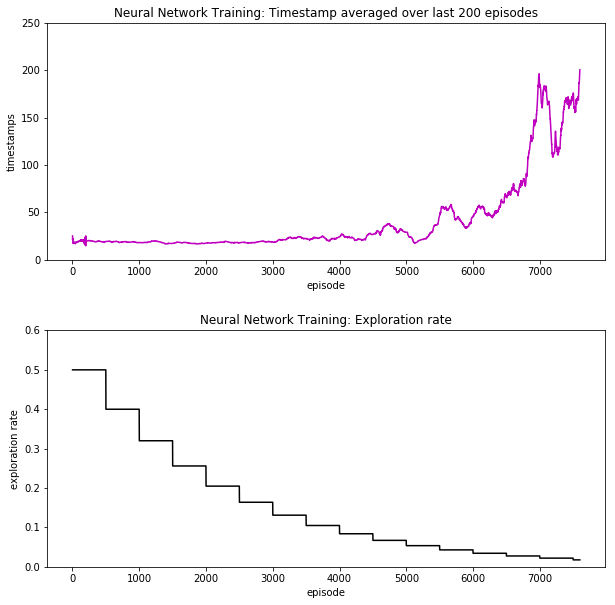

In [3]:
# plot training logs
plt.figure(figsize=[10,10])
plt.subplots_adjust(hspace=0.3)

plt.subplot(2,1,1)
plt.plot(logs['episode'], logs['avg_timestamp_last_200_episodes'], 'm')
plt.title('Neural Network Training: Timestamp averaged over last 200 episodes')
plt.ylabel('timestamps')
plt.xlabel('episode')
plt.ylim([0, 250])

plt.subplot(2,1,2)
plt.plot(logs['episode'], logs['exploration_rate'], 'k')
plt.title('Neural Network Training: Exploration rate')
plt.ylabel('exploration rate')
plt.xlabel('episode')
plt.ylim([0,0.6])

plt.savefig('../figure/plot/neural_network_plot.jpg')
plt.show()